# IY011: Variation Experiments (Varying 1 Stat)

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import pandas as pd
from utils.data_loader import baseline_data_prep
%load_ext autoreload
%autoreload 2

In [2]:
# ==========================================
# CONFIGURATION
# ==========================================
# Adjust these paths to match your actual experiment folders/CSVs
EXPERIMENTS = [
    {
        "name": "1. Baseline (Sobol)",
        "data_dir": "data",
        "csv_name": "IY011_simulation_parameters_sobol.csv",
        "color": "black"
    },
    {
        "name": "2. Mu Variation",
        # "data_dir": "temp_data_mu_variation",
        "data_dir": "data_mu_variation",
        "csv_name": "IY011_simulation_mu_parameters_sobol.csv",
        "color": "blue"
    },
    {
        "name": "3. CV Variation",
        # "data_dir": "temp_data_cv_variation",
        "data_dir": "data_cv_variation",
        "csv_name": "IY011_simulation_cv_parameters_sobol.csv",
        "color": "green"
    },
    {
        "name": "4. Tac Variation",
        # "data_dir": "temp_data_t_ac_variation",
        "data_dir": "data_t_ac_variation",
        "csv_name": "IY011_simulation_t_ac_parameters_sobol.csv",
        "color": "red"
    }
]


# check that each dataset has the expected stats

In [3]:
def plot_obs_vs_target(ax, df, target_col, obs_col, title, color):
    """Helper to create a single scatter plot with y=x line."""
    if target_col not in df.columns or obs_col not in df.columns:
        ax.text(0.5, 0.5, f"Column missing:\n{target_col} or {obs_col}", 
                ha='center', va='center', transform=ax.transAxes)
        return

    # Scatter Plot
    ax.scatter(df[target_col], df[obs_col], alpha=0.5, marker='.', color=color)
    
    # Identity Line (y=x)
    min_val = min(df[target_col].min(), df[obs_col].min())
    max_val = max(df[target_col].max(), df[obs_col].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y=x)', linewidth=1.5)
    
    # Aesthetics
    ax.set_xlabel(f'{title} Target')
    ax.set_ylabel(f'{title} Observed')
    ax.set_title(f'{title} Accuracy')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()

Loading results for: 1. Baseline (Sobol)...


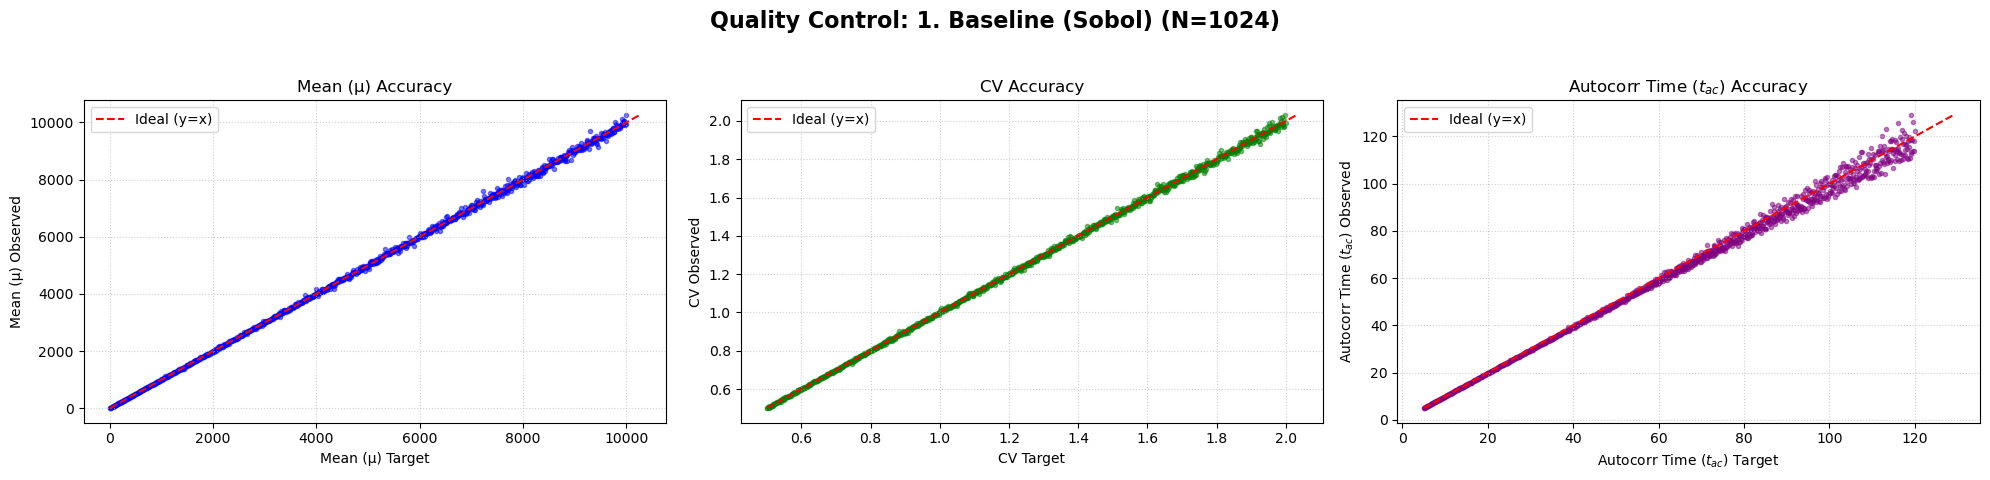

Loading results for: 2. Mu Variation...


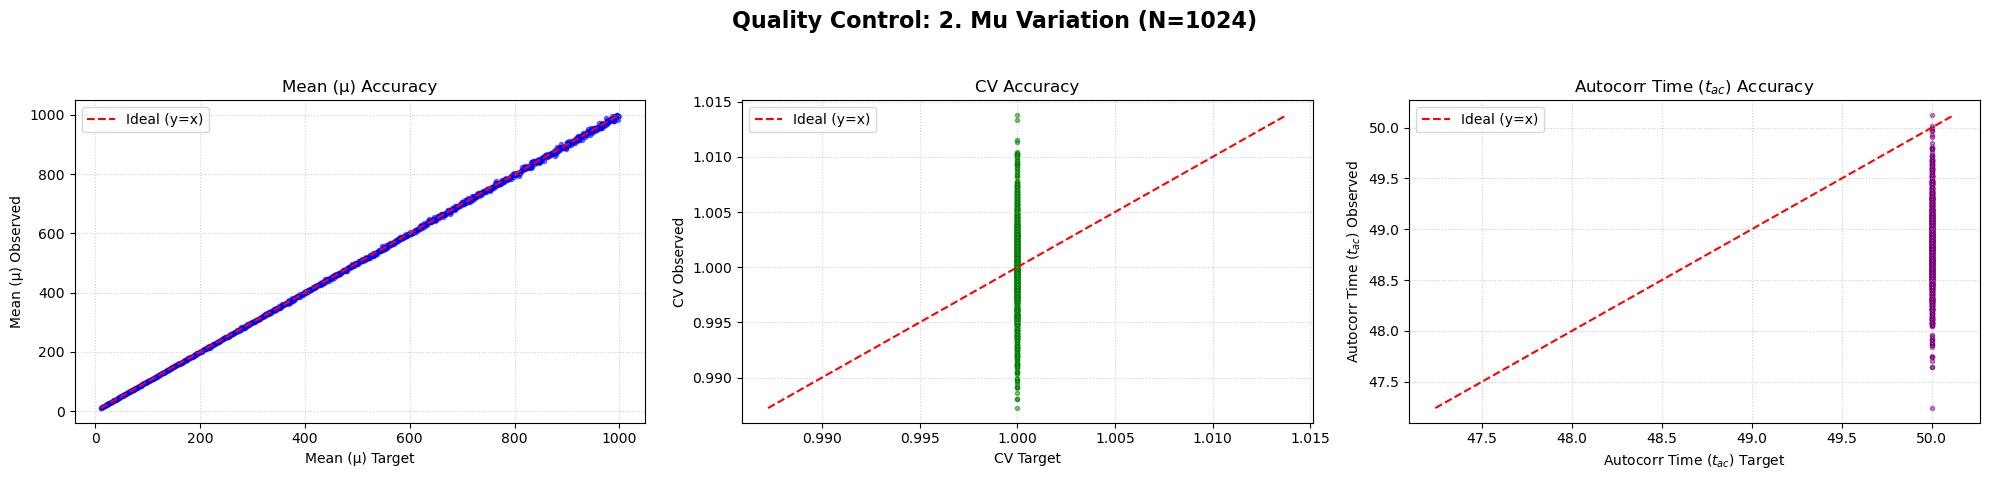

Loading results for: 3. CV Variation...


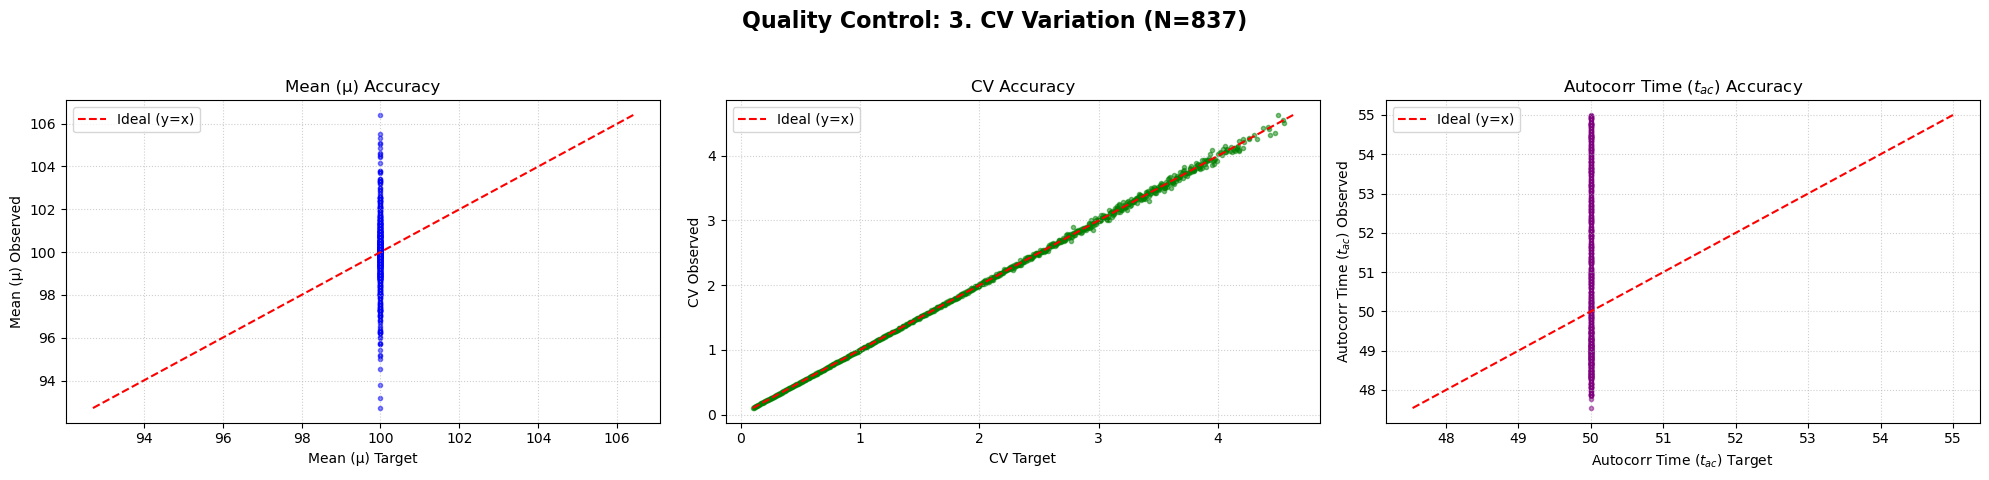

Loading results for: 4. Tac Variation...


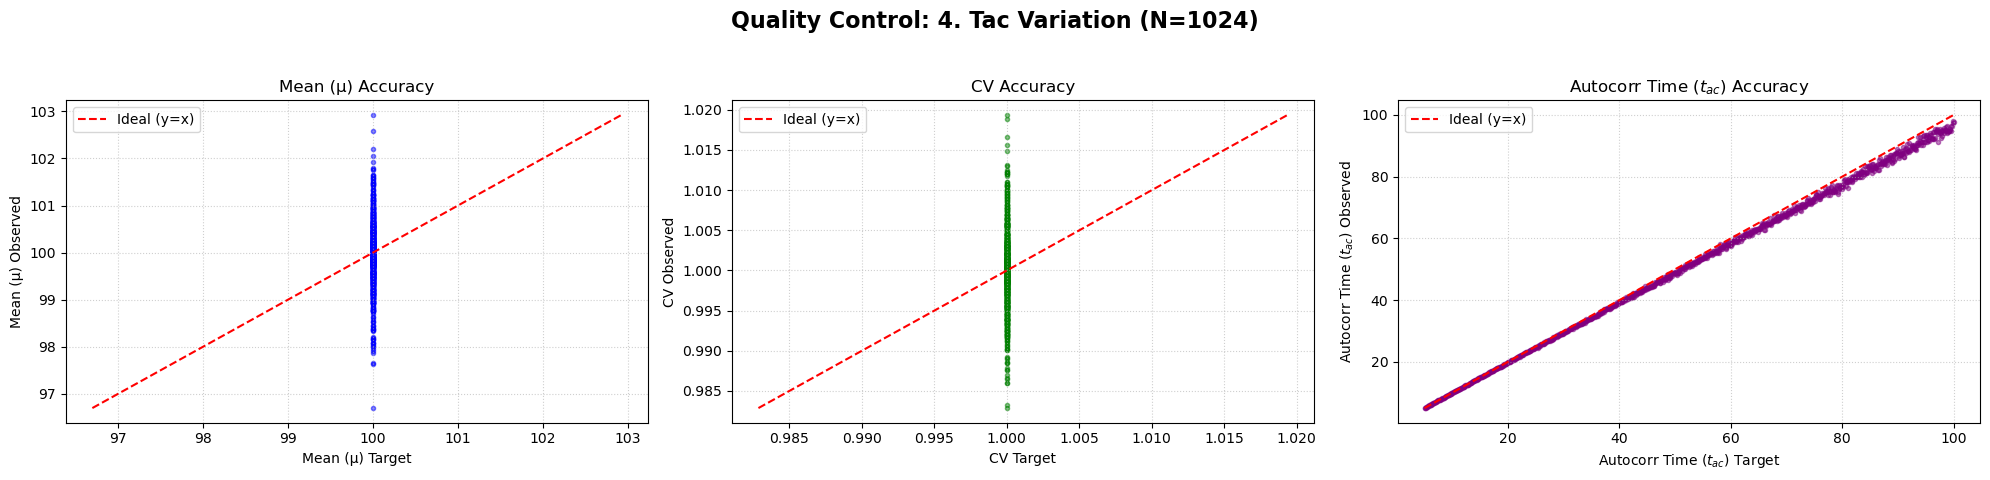

In [4]:
script_dir = Path.cwd() # Current working directory (works best in Notebooks)

for exp in EXPERIMENTS:
    csv_path = script_dir / exp["data_dir"] / exp["csv_name"]
    
    if not csv_path.exists():
        print(f"⚠️ Skipping {exp['name']}: File not found at {csv_path}")
        continue

    print(f"Loading results for: {exp['name']}...")
    try:
        df = pd.read_csv(csv_path)
        # filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
        df = df[(df['success'] == True) & 
                            (df['error_message'].isna()) &
                            (df['mean_rel_error_pct'] < 10) & 
                            (df['cv_rel_error_pct'] < 10) & 
                            (df['t_ac_rel_error_pct'] < 10)]
        
        # Create a figure with 3 subplots (Mu, CV, Tac)
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        fig.suptitle(f"Quality Control: {exp['name']} (N={len(df)})", fontsize=16, weight='bold')

        # 1. Plot Mu
        plot_obs_vs_target(axes[0], df, 'mu_target', 'mu_observed', 'Mean (μ)', 'blue')

        # 2. Plot CV
        plot_obs_vs_target(axes[1], df, 'cv_target', 'cv_observed', 'CV', 'green')

        # 3. Plot Tac
        plot_obs_vs_target(axes[2], df, 't_ac_target', 't_ac_observed', 'Autocorr Time ($t_{ac}$)', 'purple')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
        plt.show()
        
    except Exception as e:
        print(f"❌ Error processing {exp['name']}: {e}")

# visualise each dataset (after instance norm) to see differences

In [5]:
def visualize_batch(loader, exp_name, color):
    """
    Fetches one batch and plots samples from it.
    """
    try:
        # Fetch one batch
        X, y = next(iter(loader)) 
        # X shape: (Batch, Total_Time, 1)
        # y shape: (Batch, 1)
    except StopIteration:
        print(f"⚠️ Could not load batch for {exp_name}")
        return

    print(f"\n=== Visualizing: {exp_name} ===")
    print(f"Batch Shape: {X.shape}")
    print(f"Batch Stats -> Mean: {X.mean():.4f} | Std: {X.std():.4f} (Should be ~0.0 and ~1.0)")

    # Plot 4 samples
    fig, axes = plt.subplots(2, 4, figsize=(14, 8), sharex=True, sharey=True)
    fig.suptitle(f"{exp_name}\n(Instance Norm + Concatenation)", fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        if i >= len(X): break
        
        traj = X[i].flatten().numpy()
        label = y[i].item()
        
        # 1. Plot the Time Series
        ax.plot(traj, color=color, linewidth=0.8, alpha=0.8)
        
        # 2. Add visual aid for stats
        mean_val = traj.mean()
        std_val = traj.std()
        
        # Title with metadata
        label_str = "POSITIVE (Same)" if label == 1.0 else "NEGATIVE (Diff)"
        ax.set_title(f"Sample {i}: {label_str}\n$\mu$={mean_val:.2f}, $\sigma$={std_val:.2f}", fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # 3. Highlight the Zero line (since it's normalized)
        ax.axhline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # 4. Plot Histograms (Density) to see the "Shape" of the signal values
    plt.figure(figsize=(10,8))
    for i in range(8):
        sns.kdeplot(X[i].flatten().numpy(), color=color, alpha=i*0.1, fill=True, label=f"Sample {i}")
    plt.title(f"Value Distribution (Density) - {exp_name}")
    plt.xlabel("Normalized Intensity Value (Sigma)")
    plt.axvline(0, color='black', linestyle='--')
    plt.legend()
    plt.show()

Loading data for 1. Baseline (Sobol)...
Files split: 655 Train, 164 Val, 205 Test
Generating 10 training groups...


  0%|          | 0/10 [00:00<?, ?it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_7313.901_1.028_12.552.npz
 B: mRNA_trajectories_9606.290_1.932_80.735.npz


 20%|██        | 2/10 [00:00<00:01,  5.42it/s]

Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_5530.242_1.939_31.594.npz
 B: mRNA_trajectories_6697.291_1.106_46.868.npz


 40%|████      | 4/10 [00:00<00:01,  4.56it/s]

Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_7812.415_1.015_36.226.npz
 B: mRNA_trajectories_9152.688_0.608_13.854.npz


 50%|█████     | 5/10 [00:01<00:01,  4.39it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_8451.545_1.542_119.383.npz
 B: mRNA_trajectories_8145.629_0.720_84.335.npz


 60%|██████    | 6/10 [00:01<00:01,  3.85it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_2410.649_0.644_55.682.npz
 B: mRNA_trajectories_3238.956_1.290_86.243.npz


 80%|████████  | 8/10 [00:01<00:00,  4.51it/s]

Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_1595.980_0.999_48.396.npz
 B: mRNA_trajectories_5762.098_0.863_106.273.npz


 90%|█████████ | 9/10 [00:02<00:00,  4.27it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_8187.457_1.848_56.798.npz
 B: mRNA_trajectories_9379.667_1.754_11.791.npz


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Generating validation groups...


  0%|          | 0/1 [00:00<?, ?it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_3967.237_1.581_79.933.npz
 B: mRNA_trajectories_7923.384_1.824_82.352.npz


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Generating test groups...


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


Generating POSITIVE group.
Batch Mean (should be ~0): -0.0000
Batch Std  (should be ~1): 0.9999
Min Value: -1.40, Max Value: 9.59

=== Visualizing: 1. Baseline (Sobol) ===
Batch Shape: torch.Size([8, 3623, 1])
Batch Stats -> Mean: 0.0000 | Std: 0.9999 (Should be ~0.0 and ~1.0)


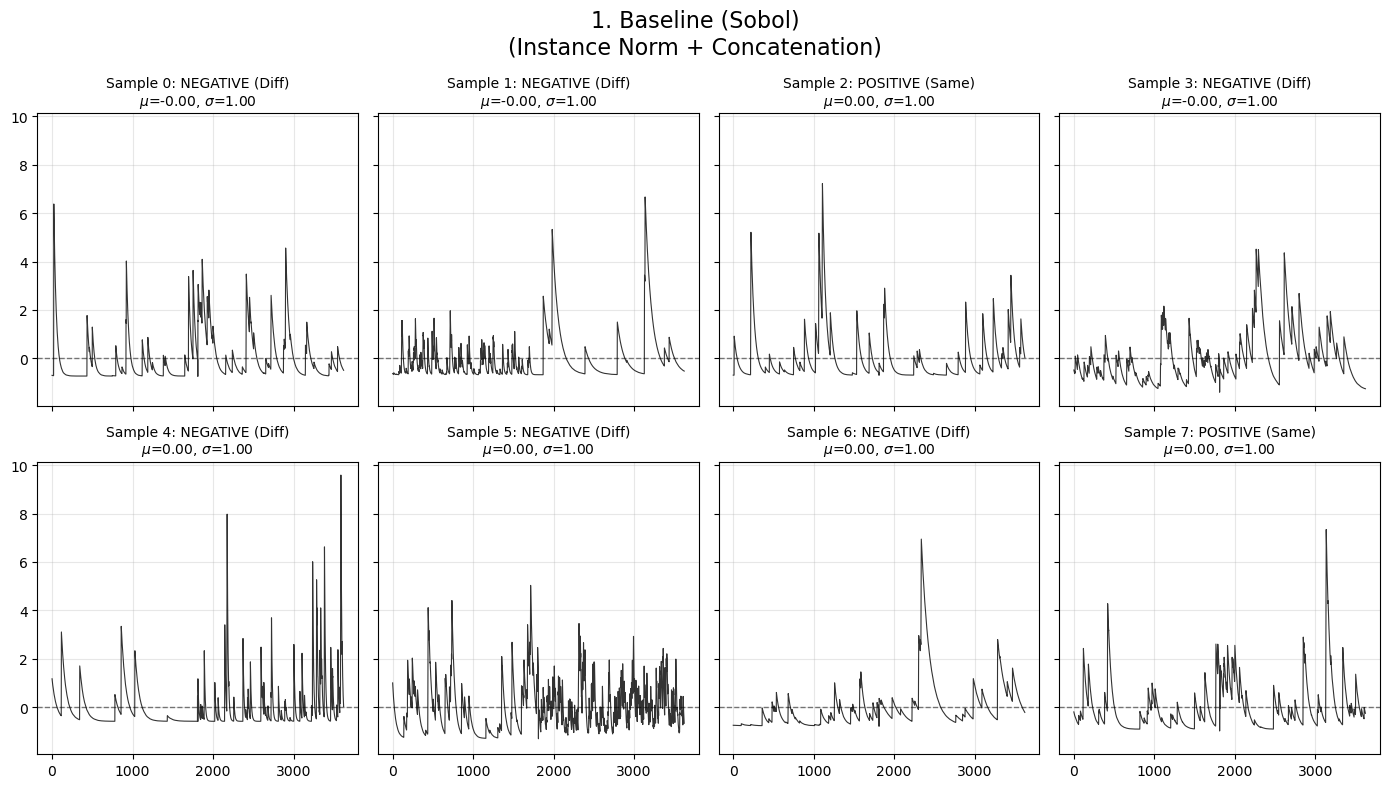

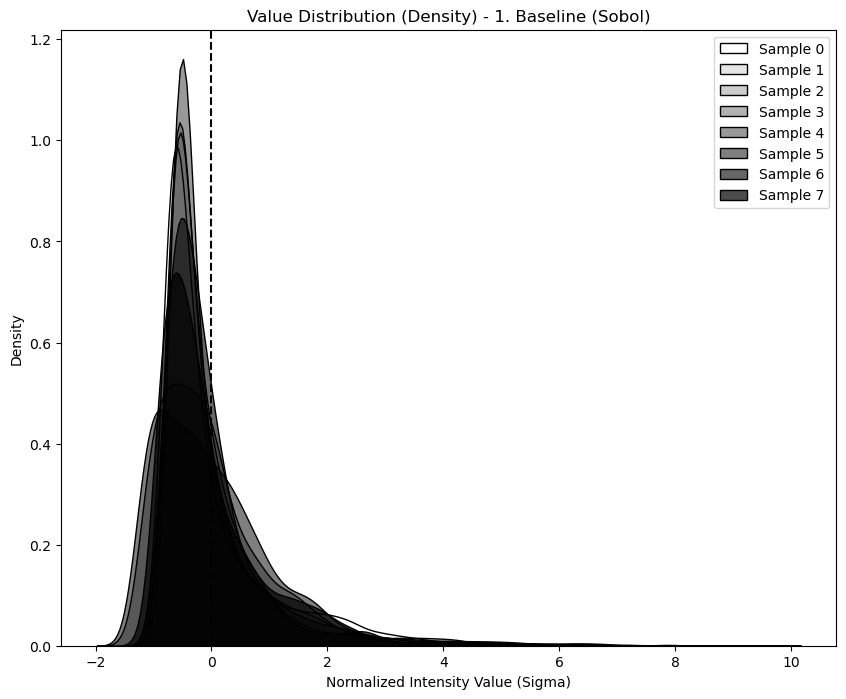

Loading data for 2. Mu Variation...
Files split: 655 Train, 164 Val, 205 Test
Generating 10 training groups...


 20%|██        | 2/10 [00:00<00:00, 13.35it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_921.881_1.000_50.000.npz
 B: mRNA_trajectories_78.997_1.000_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_798.031_1.000_50.000.npz
 B: mRNA_trajectories_355.192_1.000_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_252.381_1.000_50.000.npz
 B: mRNA_trajectories_745.696_1.000_50.000.npz


 60%|██████    | 6/10 [00:00<00:00, 15.12it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_805.141_1.000_50.000.npz
 B: mRNA_trajectories_277.191_1.000_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_271.935_1.000_50.000.npz
 B: mRNA_trajectories_579.724_1.000_50.000.npz
Generating POSITIVE group.
Generating POSITIVE group.


100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_559.983_1.000_50.000.npz
 B: mRNA_trajectories_235.772_1.000_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_949.337_1.000_50.000.npz
 B: mRNA_trajectories_405.606_1.000_50.000.npz
Generating POSITIVE group.
Generating validation groups...


  0%|          | 0/1 [00:00<?, ?it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_978.714_1.000_50.000.npz
 B: mRNA_trajectories_348.400_1.000_50.000.npz


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Generating test groups...


100%|██████████| 1/1 [00:00<00:00, 26.45it/s]


Generating POSITIVE group.
Batch Mean (should be ~0): -0.0000
Batch Std  (should be ~1): 0.9999
Min Value: -1.24, Max Value: 9.33

=== Visualizing: 2. Mu Variation ===
Batch Shape: torch.Size([8, 5021, 1])
Batch Stats -> Mean: -0.0000 | Std: 0.9999 (Should be ~0.0 and ~1.0)


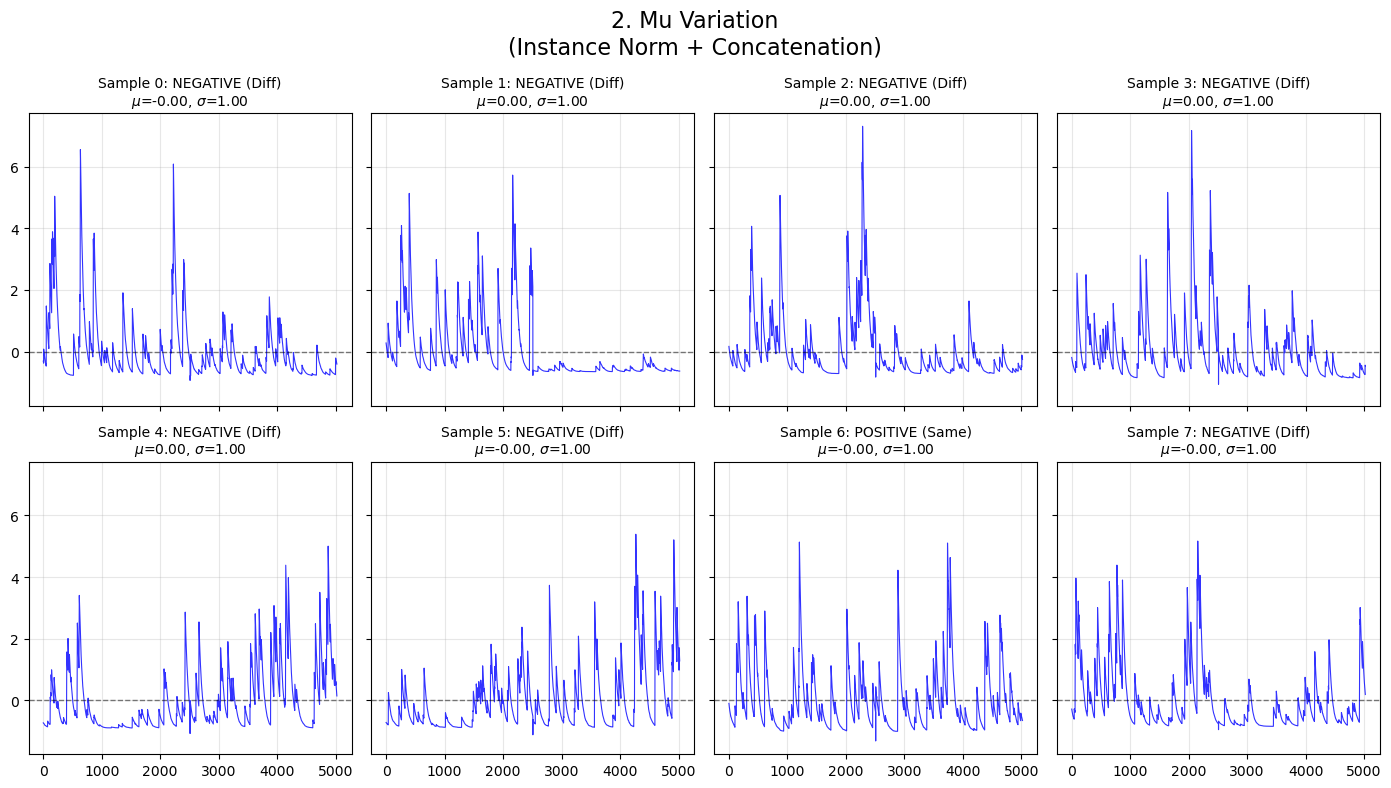

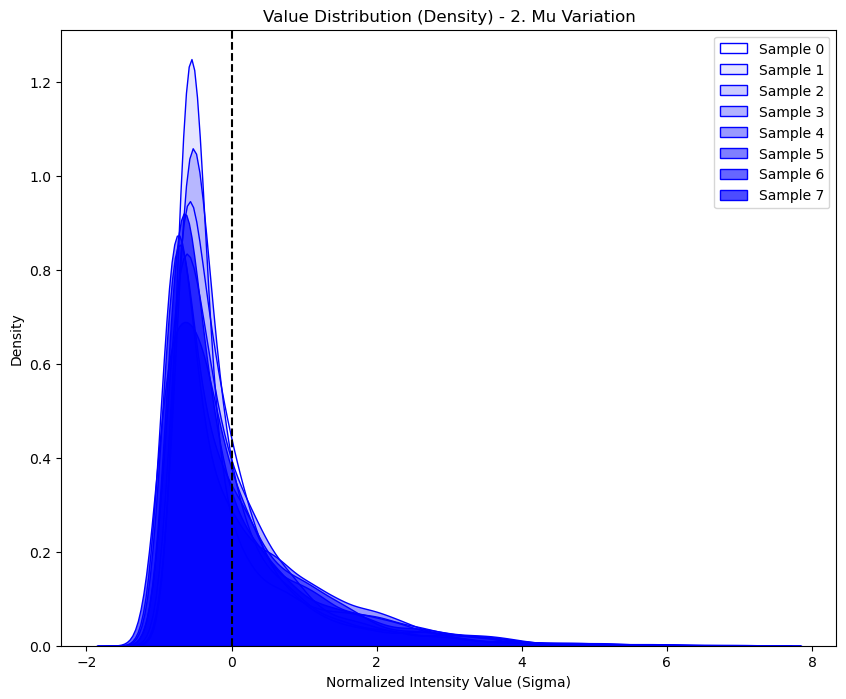

Loading data for 3. CV Variation...
Files split: 535 Train, 134 Val, 168 Test
Generating 10 training groups...


 30%|███       | 3/10 [00:00<00:00, 19.60it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.527_50.000.npz
 B: mRNA_trajectories_100.000_3.218_50.000.npz
Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.151_50.000.npz
 B: mRNA_trajectories_100.000_0.180_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.453_50.000.npz
 B: mRNA_trajectories_100.000_0.633_50.000.npz


 60%|██████    | 6/10 [00:00<00:00, 22.25it/s]

Generating POSITIVE group.
Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_3.258_50.000.npz
 B: mRNA_trajectories_100.000_1.050_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.672_50.000.npz
 B: mRNA_trajectories_100.000_0.398_50.000.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.620_50.000.npz
 B: mRNA_trajectories_100.000_0.374_50.000.npz


100%|██████████| 10/10 [00:00<00:00, 18.58it/s]


Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.245_50.000.npz
 B: mRNA_trajectories_100.000_3.460_50.000.npz
Generating validation groups...


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_3.173_50.000.npz
 B: mRNA_trajectories_100.000_0.935_50.000.npz
Generating test groups...


  0%|          | 0/1 [00:00<?, ?it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_2.471_50.000.npz
 B: mRNA_trajectories_100.000_0.630_50.000.npz


100%|██████████| 1/1 [00:00<00:00, 14.32it/s]


Batch Mean (should be ~0): -0.0000
Batch Std  (should be ~1): 0.9999
Min Value: -2.42, Max Value: 11.60

=== Visualizing: 3. CV Variation ===
Batch Shape: torch.Size([8, 5003, 1])
Batch Stats -> Mean: -0.0000 | Std: 0.9999 (Should be ~0.0 and ~1.0)


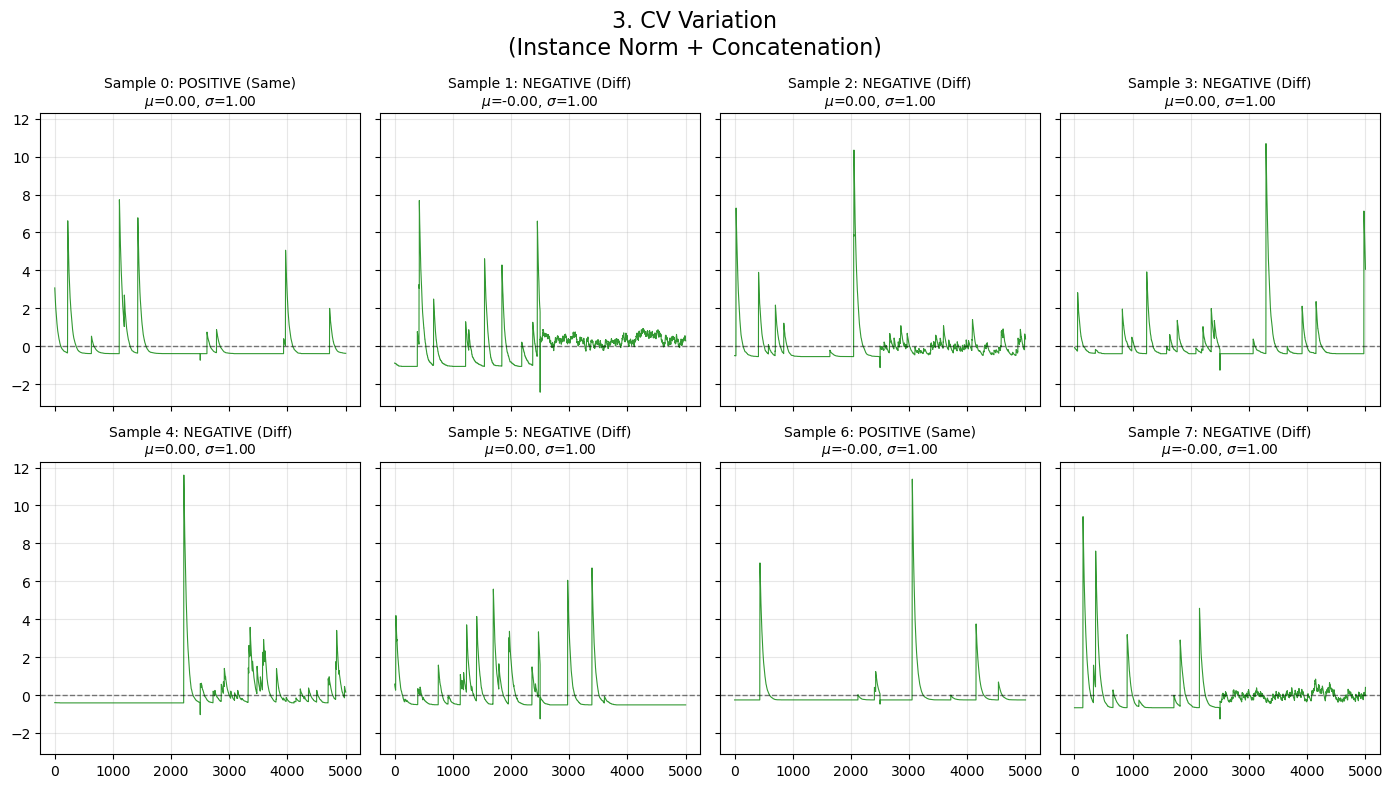

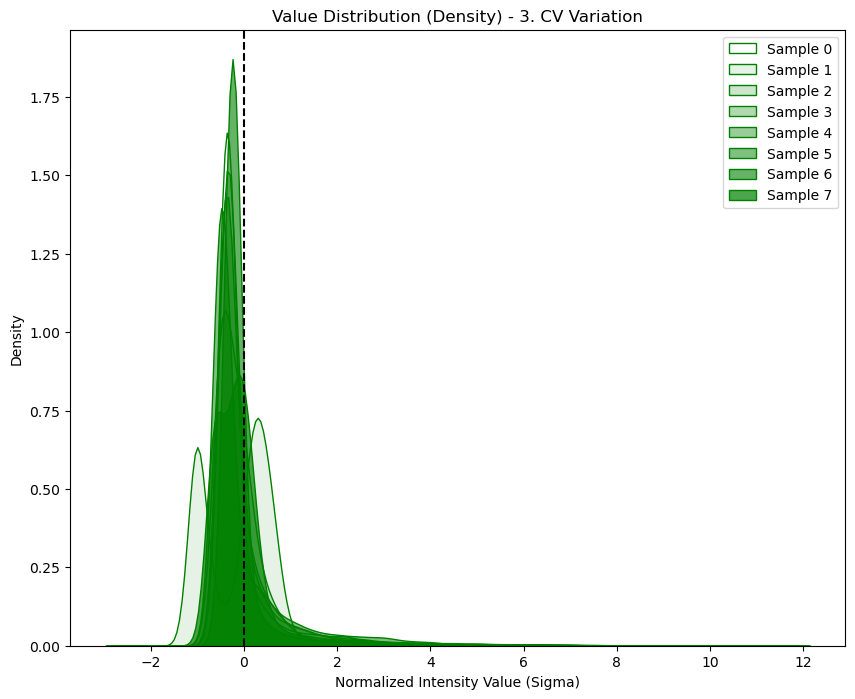

Loading data for 4. Tac Variation...
Files split: 655 Train, 164 Val, 205 Test
Generating 10 training groups...


 20%|██        | 2/10 [00:00<00:00, 17.96it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_92.504.npz
 B: mRNA_trajectories_100.000_1.000_11.621.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_80.619.npz
 B: mRNA_trajectories_100.000_1.000_38.124.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_28.259.npz
 B: mRNA_trajectories_100.000_1.000_75.597.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_81.301.npz
 B: mRNA_trajectories_100.000_1.000_30.640.npz


 60%|██████    | 6/10 [00:00<00:00, 17.47it/s]

Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_30.135.npz
 B: mRNA_trajectories_100.000_1.000_74.493.npz
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_37.170.npz
 B: mRNA_trajectories_100.000_1.000_11.621.npz
Generating POSITIVE group.
Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_78.457.npz
 B: mRNA_trajectories_100.000_1.000_26.665.npz


100%|██████████| 10/10 [00:00<00:00, 19.45it/s]


Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_95.138.npz
 B: mRNA_trajectories_100.000_1.000_42.962.npz
Generating POSITIVE group.
Generating validation groups...


100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Generating NEGATIVE group.
Selected files:
 A: mRNA_trajectories_100.000_1.000_97.957.npz
 B: mRNA_trajectories_100.000_1.000_37.473.npz
Generating test groups...


100%|██████████| 1/1 [00:00<00:00, 35.37it/s]

Generating POSITIVE group.
Batch Mean (should be ~0): -0.0000
Batch Std  (should be ~1): 0.9999
Min Value: -2.46, Max Value: 6.60

=== Visualizing: 4. Tac Variation ===
Batch Shape: torch.Size([8, 4023, 1])
Batch Stats -> Mean: 0.0000 | Std: 0.9999 (Should be ~0.0 and ~1.0)


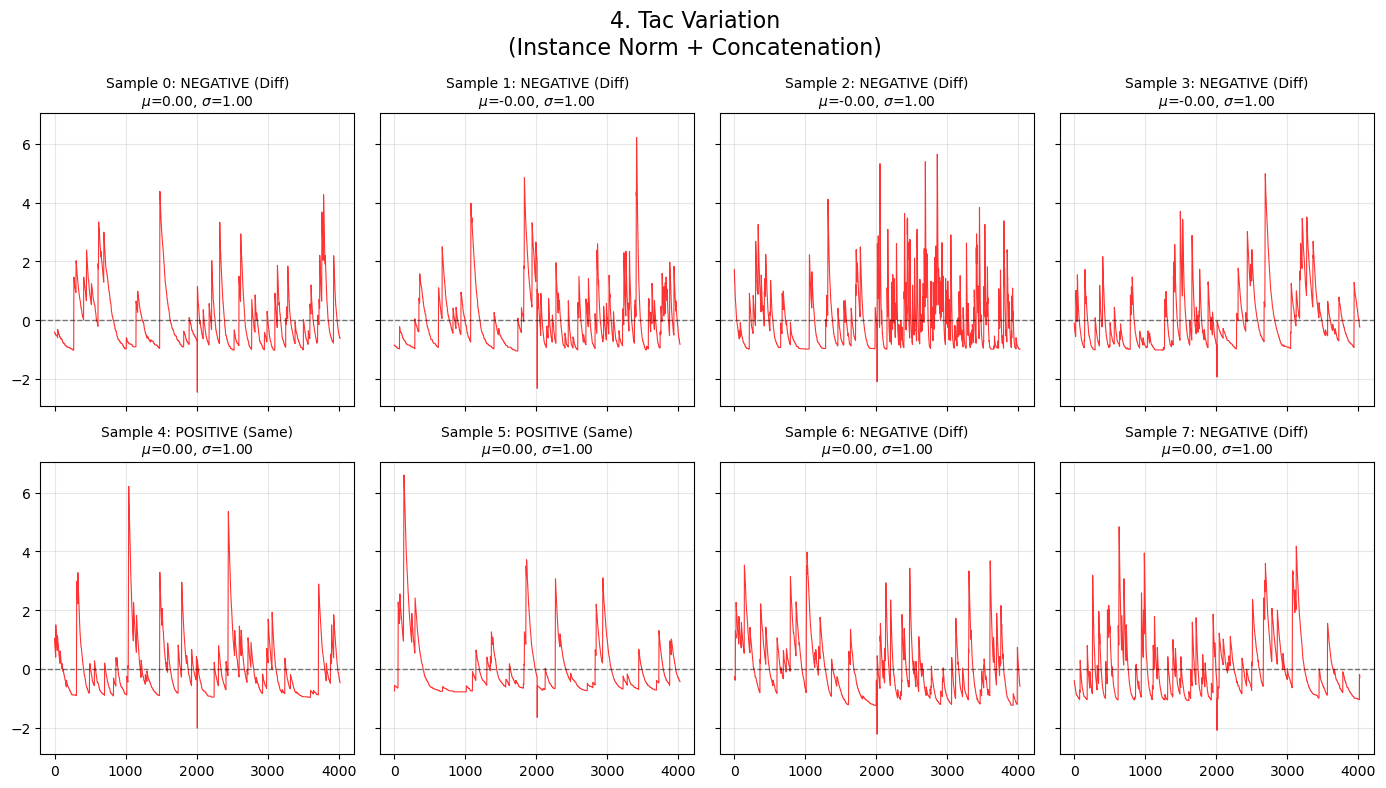

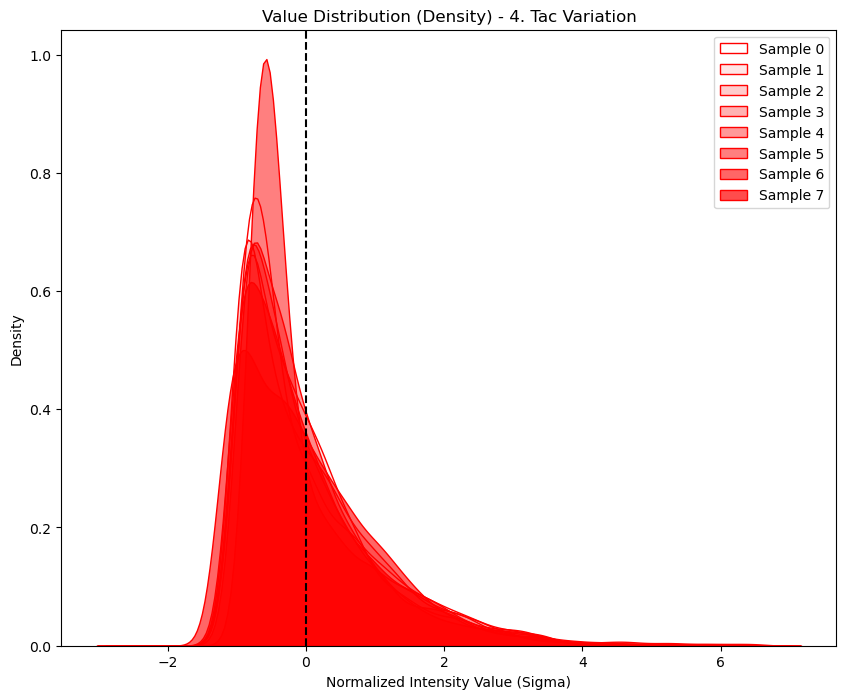

In [13]:
script_dir = Path.cwd()

for exp in EXPERIMENTS:
    data_root = script_dir / exp["data_dir"]
    results_path = data_root / exp["csv_name"]
    
    if not results_path.exists():
        print(f"❌ Skipping {exp['name']}: CSV not found at {results_path}")
        continue
        
    # Read parameters to get file lists
    try:
        df_params = pd.read_csv(results_path)
        # filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
        df_params = df_params[(df_params['success'] == True) & 
                            (df_params['error_message'].isna()) &
                            (df_params['mean_rel_error_pct'] < 10) & 
                            (df_params['cv_rel_error_pct'] < 10) & 
                            (df_params['t_ac_rel_error_pct'] < 10)]
        
        # Reconstruct file paths
        # Note: Adjust column name 'trajectory_filename' if your CSV uses a different one
        if 'trajectory_filename' in df_params.columns:
            traj_paths = [data_root / fname for fname in df_params['trajectory_filename'].values]
            traj_npz_paths = [p.with_suffix('.npz') for p in traj_paths]
        else:
            print(f"⚠️ Column 'trajectory_filename' not found in {exp['csv_name']}. Skipping.")
            continue
            
        # Initialize Loader using your function
        # We use a small num_groups just to get the loader ready
        print(f"Loading data for {exp['name']}...")
        train_loader, _, _, _ = baseline_data_prep(
            traj_npz_paths,
            batch_size=8,        # Small batch for visualization
            num_groups_train=10, # Minimal groups needed
            num_groups_val=1,
            num_groups_test=1,
            num_traj=2,        
            pos_ratio=0.5,
            verbose=True
        )
        
        # Visualize
        visualize_batch(train_loader, exp["name"], exp["color"])
        
    except Exception as e:
        print(f"❌ Error processing {exp['name']}: {e}")
        import traceback
        traceback.print_exc()

# compare SVM benchmarking scores vs transformer scores for each experiment

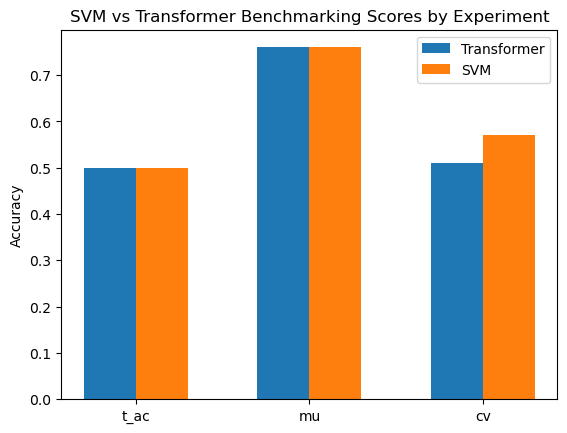

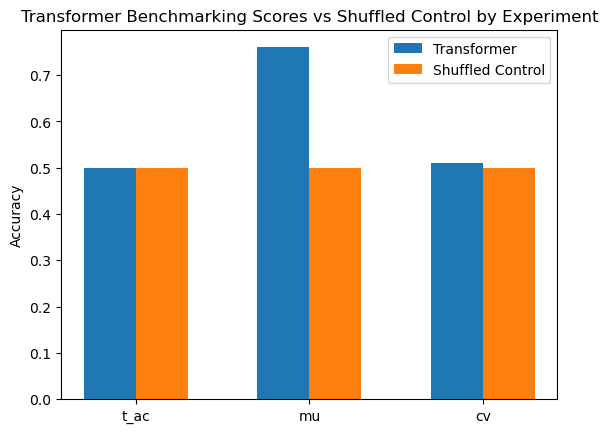

In [ ]:
# from output logs of each experiment
# t_ac experiment 
test_acc_tac = 0.50 
test_acc_tac_shuffled = 0.50
svm_acc_tac = 0.50
# mu experiment
test_acc_mu = 0.76
test_acc_mu_shuffled = 0.50
svm_acc_mu = 0.76
# cv experiment
test_acc_cv = 0.51
test_acc_cv_shuffled = 0.50
svm_acc_cv = 0.57   
# plot results (transformer vs SVM)
labels = ['t_ac', 'mu', 'cv']
transformer_scores = [test_acc_tac, test_acc_mu, test_acc_cv]
svm_scores = [svm_acc_tac, svm_acc_mu, svm_acc_cv]
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, transformer_scores, width, label='Transformer')
rects2 = ax.bar(x + width/2, svm_scores, width, label='SVM')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('SVM vs Transformer Benchmarking Scores by Experiment')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend() 
plt.show()
# plot results showing shuffled control scores
shuffled_scores = [test_acc_tac_shuffled, test_acc_mu_shuffled, test_acc_cv_shuffled]
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, transformer_scores, width, label='Transformer')
rects2 = ax.bar(x + width/2, shuffled_scores, width, label='Shuffled Control')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Transformer Benchmarking Scores vs Shuffled Control by Experiment')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()
